In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [3]:
# Generate dataset with 40 features
X, _ = make_blobs(n_samples=5_000, n_features=40, centers=10, random_state=42, cluster_std=5.0)
# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [4]:
# Initialize the maximum silhouette score to be a very small number
max_silhouette = -1
optimal_n = -1

# Try GMM clustering with n_components from 2 to 10
for n_components in range(2, 11):
    print('Fitting with K = {}'.format(n_components))
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca)
    cluster_labels = gmm.predict(X_pca)

    # Get the silhouette score
    silhouette = silhouette_score(X_pca, cluster_labels)

    # If the silhouette score is the maximum so far, update max_silhouette and optimal_n
    if silhouette > max_silhouette:
        max_silhouette = silhouette
        optimal_n = n_components

print("Optimal number of components {0} has silhouette score of {1}".format(optimal_n, np.round(max_silhouette,3)))

Fitting with K = 2
Fitting with K = 3
Fitting with K = 4
Fitting with K = 5
Fitting with K = 6
Fitting with K = 7
Fitting with K = 8
Fitting with K = 9
Fitting with K = 10
Optimal number of components 5 has silhouette score of 0.537


In [5]:
gmm = GaussianMixture(n_components=optimal_n, random_state=42)
gmm.fit(X_pca)
cl = gmm.predict(X_pca)

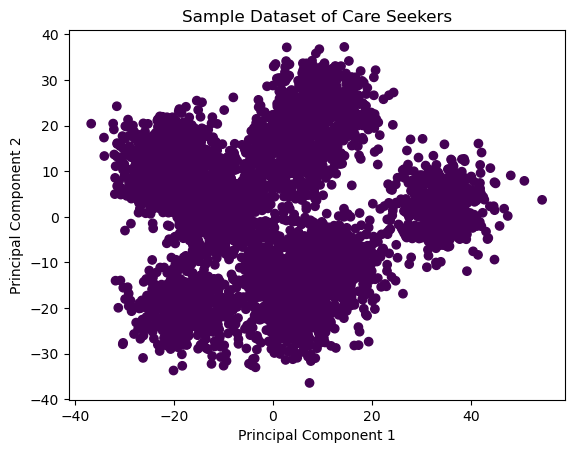

In [18]:
# Plot the dataset after PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.zeros(5000))
plt.title("Sample Dataset of Care Seekers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

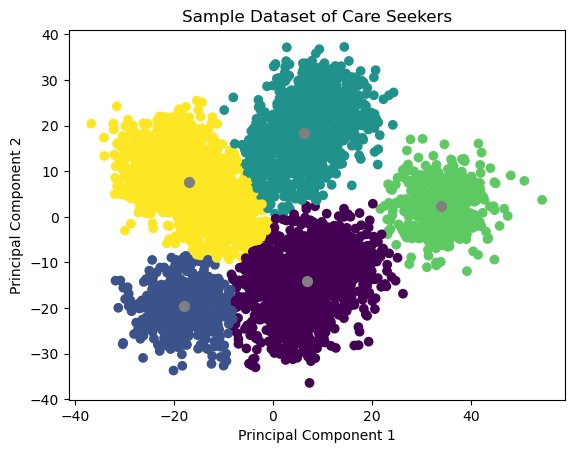

In [27]:
# Plot the dataset after PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cl)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='gray', marker='o', s=50) # plot centroids in red
plt.title("Sample Dataset of Care Seekers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [7]:
probas = gmm.predict_proba(X_pca)

In [8]:
# Suppose we have some data on the facilities chosen by each care seeker
# This is a placeholder for the actual data
chosen_facilities = np.random.choice(np.arange(1, 51), size=5000)  # 50 facilities to choose from

In [9]:
# Soft clustering: each sample belongs to each cluster with a certain probability
cluster_proba = gmm.predict_proba(X_pca)
# Create a preference matrix: each row corresponds to a cluster, each column to a facility
preference_matrix = np.zeros((optimal_n, 50))  # Assuming 10 clusters and 50 facilities

In [10]:
# Update the preference matrix based on the data
for seeker, facility in enumerate(chosen_facilities):
    for cluster, proba in enumerate(cluster_proba[seeker]):
        preference_matrix[cluster, facility-1] += proba  # facility-1 is the index of the facility

# Normalize the preference matrix (so that each row sums to 1)
preference_matrix /= preference_matrix.sum(axis=1, keepdims=True)

# Now, for each care seeker, we can calculate the expected preference for each facility
expected_preferences = cluster_proba @ preference_matrix

# For each care seeker, find the facility with the highest expected preference
recommended_facilities = np.argmax(expected_preferences, axis=1) + 1  # +1 because facilities are 1-indexed

In [11]:
recommended_facilities

array([ 9,  9, 32, ...,  9, 16, 32], dtype=int64)

In [12]:
expected_preferences

array([[0.01635098, 0.01586942, 0.01119409, ..., 0.02058117, 0.02308806,
        0.01436647],
       [0.016267  , 0.01583958, 0.01102943, ..., 0.02050432, 0.02333616,
        0.01412906],
       [0.01853457, 0.01663613, 0.01555204, ..., 0.02260797, 0.01646697,
        0.02071058],
       ...,
       [0.01639397, 0.01589923, 0.0111561 , ..., 0.02057488, 0.02323337,
        0.01421402],
       [0.02488565, 0.02017183, 0.02043233, ..., 0.02536543, 0.01735157,
        0.01958715],
       [0.01759432, 0.01663756, 0.01685405, ..., 0.02249404, 0.01745223,
        0.02114804]])

In [13]:
np.unique(recommended_facilities, return_counts=True)

(array([ 6,  9, 10, 14, 16, 22, 31, 32, 34, 35, 41, 42, 48], dtype=int64),
 array([ 495, 1010,   11,    1,   31, 1466,   13, 1375,  494,   80,    7,
          11,    6], dtype=int64))